# Background

This notebook will show how to import a stack of DICOM images and place them in numpy

Following this tutorial:
- [DICOM in Python: Importing medical image data into NumPy with PyDICOM and VTK](https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/)

# Imports

Make sure that VTK is properly installed using the 

pip install pydicom command

In [1]:
import vtk
from vtk.util import numpy_support
import os
import numpy
from matplotlib import pyplot, cm
%pylab inline

import scipy.misc

Populating the interactive namespace from numpy and matplotlib


# Reading files

If you check the database folder you’ll see that the .dcm files are named **00.dcm, **01.dcm, etc. Where ** is the name of the patient of files.  These are in the same directory because they are from the same patient.  This means that each DICOM file is associated with a slide.  Together they make up the volumentric data of the scanned item.  

The walk function will return them in order since they’re sorted lexicographically by the OS. However, in many cases DICOM files don’t have all those leading zeros, with names like MR1, MR2, etc which would result in lstFilesDCM having the filenames ordered in a fashion such as MR1, MR10, MR100, etc. Since, the typical sorting functions in python, such as sorted and the sort method of list objects (docs here), are lexicographical as well (unless dealing with pure numbers), I strongly suggest using the very useful natsort package which can be found on PyPI here (and can be installed with a simple pip install natsort).

We first create a **vtkDICOMImageReader** object (docs here), and pass the path to the directory where all the .dcm files are through the **SetDirectoryName** method. After that, its just a matter of calling the Update method which does all the reading. If you were dealing with huge datasets, you’d be surprised how much faster than pydicom VTK does that.

In [2]:
PathDicom = "C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Marcus Rat Brain//901-T1FFECorPostC SENSE-693.3"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

Next we need access to the metadata in order to calculate those **ConstPixelDims** and **ConstPixelSpacing** variables:

In [3]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

In [4]:
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

As you can see, the vtkDICOMImageReader class comes with a few useful methods that provide the metadata straight-up. However, only a few of those values are available in a straightforward manner. Thankfully, by using the GetDataExtent method of the reader we get a 6-value tuple with the starting and stopping indices of the resulting array on all three axes. Obviously, that’s all we need to calculate the size of the array. Getting the pixel-spacing is even easier than with pydicom and simply accomplished with the GetPixelSpacing method.

Now, onto the fun part :). You might have read my previous post on how to convert arrays between NumPy and VTK. You might have thought that we can use that functionality and get a nice NumPy array with a one-liner. Well, I hate to disappoint you but it’s not that straightforward (remember, VTK).

If you dig a little into the **vtkDICOMImageReader** docs, you will see that it inherits **vtkImageReader2**, which in turn inherits **vtkImageAlgorithm**. The latter, sports a **GetOutput** method returning a **vtkImageData** object pointer. However, the **numpy_support.vtk_to_numpy** function only works on **vtkArray** objects so we need to dig into the **vtkImageData** object till we get that type of array. Here’s how we do that:

In [5]:
# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

As you can see, we initially use reader.GetOutput() to get a vtkImageData object pointer into imageData. We then use the GetPointData method of that object to ‘extract’ a vtkPointData object pointer into pointData. Now, these vtkPointData may hold multiple arrays but we should only have one in there (being the entirety of the DICOM data). Since these ‘internal’ arrays are numerically indexed, we get this vtkArray through index 0 so the array we were looking for can be retrieved through arrayData = pointData.GetArray(0). We can now finally ‘convert’ that pesky array to NumPy through vtk_to_numpy and store it in ArrayDicom. As a final step, we reshape that array using ConstPixelDims et voila!

# Visualization

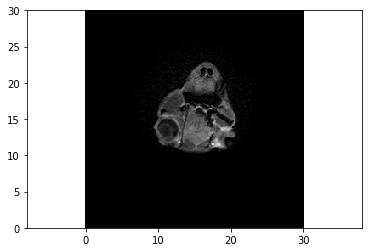

In [6]:
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, numpy.flipud(numpy.rot90(ArrayDicom[:, :, 3])))

# Saving

In [8]:
ArrayDicom.shape

(256L, 256L, 48L)

In [16]:
PathDicom = "C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Marcus Rat Brain//901-T1FFECorPostC SENSE-693.3"
OutFile = PathDicom + ' Image Stack//'

In [24]:
numSlices = ArrayDicom.shape[2]

In [25]:
for sliceInd in xrange(numSlices):
    scipy.misc.imsave(OutFile + 'Rat Slice {}.jpg'.format(sliceInd), numpy.rot90(ArrayDicom[:, :, sliceInd]))

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [18]:
slice = 0
scipy.misc.imsave(OutFile + 'Rat Slice {}.jpg'.format(slice), numpy.rot90(ArrayDicom[:, :, 3]))

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
